In [1]:
%matplotlib inline

# Builtins
from datetime import datetime
from collections import OrderedDict

# Core Numerics
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Data Analysis
import xarray as xr
from xarray.core.common import _full_like as full_like
import pandas as pd
# import geopandas

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

from rasmlib.calendar import get_dpm

In [2]:
# projection class
class Rasm(ccrs.Projection):

    def __init__(self):

        proj4_params = {'R': 6371200.0,
                        'lat_0': 90.0,
                        'lat_1': 90,
                        'lat_2': 90,
                        'lon_0': -114.0+360,
                        'proj': 'lcc',
                        'units': 'm',
                        'x_0': 9469302.950316086,
                        'y_0': 6201952.603370549}

        super(Rasm, self).__init__(proj4_params)

    @property
    def boundary(self):
        coords = ((self.x_limits[0], self.y_limits[0]),(self.x_limits[1], self.y_limits[0]),
                  (self.x_limits[1], self.y_limits[1]),(self.x_limits[0], self.y_limits[1]),
                  (self.x_limits[0], self.y_limits[0]))

        return ccrs.sgeom.Polygon(coords).exterior

    @property
    def threshold(self):
        return 100000.0

    @property
    def x_limits(self):
        return (0, 16423961.103252266)

    @property
    def y_limits(self):
        return (0, 12228062.194885937)

    
def read_obs_seaice_extent():
#     df = pd.read_csv('ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/NH_seaice_extent_final.csv', skiprows=[1])
    df = pd.read_csv('ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/NH_seaice_extent_final_v2.csv', skiprows=[1])
    df.columns = [c.strip() for c in df.columns]
    df.index = [datetime(int(row['Year']), int(row['Month']), int(row['Day'])) for _, row in df.iterrows()]
    
    return df['Extent']


def read_grid_prec(kind='Adam'):
    if kind == 'Adam':
        da = xr.open_dataset('/raid2/jhamman/projects/RASM/data/compare/adam2003/adam2003_wr50a.mm.nc').rename({'y': 'nj', 'x': 'ni'})['Precip'].sel(time=slice('1980-01-01', '2004-12-31'))
        dpm = xr.DataArray(get_dpm(da.time.to_index(), calendar='standard'),
                           dims=('time', ), coords={'time': da.time}, name='dpm')
    elif kind == 'ERA':
        da = xr.open_dataset('/raid2/jhamman/projects/RASM/data/compare/era-interim/era_water_vars.1979-2014.nc').rename({'y': 'nj', 'x': 'ni', 'tp': 'Precip'})['Precip'].sel(time=slice('1980-01-01', '2014-12-31')) * 1000
        dpm = xr.DataArray(get_dpm(da.time.to_index(), calendar='noleap'),
                           dims=('time', ), coords={'time': da.time}, name='dpm')
    elif kind == 'MERRA':
        da = xr.open_dataset('/raid2/jhamman/projects/RASM/data/compare/MERRA/monthly/MERRA.prod.assim.tavgM_2d_lnd_Nx.197901-201312.SUB.wr50a.nc').rename({'y': 'nj', 'x': 'ni', 'prectot': 'Precip'})['Precip']  * 86400
        da = da.isel(time=np.argsort(da.time.to_index().to_julian_date()))
        da = da.sel(time=slice('1980-01-01', '2013-12-31'))
        dpm = xr.DataArray(get_dpm(da.time.to_index(), calendar='noleap'),
                           dims=('time', ), coords={'time': da.time}, name='dpm')
    elif kind == 'RASM':
        ds = xr.open_dataset('/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/cpl/monthly_mean_timeseries/R1010RBRbaaa01a.cpl.hmm.197909-201412.nc').rename(
            {'x2aavg_ny': 'nj', 'x2aavg_nx': 'ni', 'a2xavg_ny': 'nj', 'a2xavg_nx': 'ni'}).sel(time=slice('1980-01-01', '2014-12-31'))
        da = (ds['a2xavg_Faxa_rainc'] + ds['a2xavg_Faxa_rainl'] + ds['a2xavg_Faxa_snowc'] + ds['a2xavg_Faxa_snowl']) * 86400
        dpm = xr.DataArray(get_dpm(da.time.to_index(), calendar='noleap'),
                           dims=('time', ), coords={'time': da.time}, name='dpm')
    elif kind == 'RASM_RSH':
        ds = xr.open_dataset('/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsh01a/cpl/monthly_mean_timeseries/R1010RBRbrsh01a.cpl.hmm.197909-201412.nc').rename(
            {'x2aavg_ny': 'nj', 'x2aavg_nx': 'ni', 'a2xavg_ny': 'nj', 'a2xavg_nx': 'ni'}).sel(time=slice('1980-01-01', '2014-12-31'))
        da = (ds['a2xavg_Faxa_rainc'] + ds['a2xavg_Faxa_rainl'] + ds['a2xavg_Faxa_snowc'] + ds['a2xavg_Faxa_snowl']) * 86400
        dpm = xr.DataArray(get_dpm(da.time.to_index(), calendar='noleap'),
                           dims=('time', ), coords={'time': da.time}, name='dpm')
    else:
        raise ValueError('Unknown prec kind %s' % kind)
                
    return da * dpm


def read_grid_convergence(kind='ERA'):
    if kind == 'ERA':
        ds = xr.open_dataset(
            '/raid2/jhamman/projects/RASM/data/compare/era-interim/era_water_vars.1979-2014.nc').rename(
                {'y': 'nj', 'x': 'ni'}).sel(time=slice('1980-01-01', '2014-12-31'))
        da = (ds['tp'] + ds['e']) * 1000.
        dpm = xr.DataArray(get_dpm(da.time.to_index(), calendar='standard'),
                           dims=('time', ), coords={'time': da.time}, name='dpm')
    elif kind == 'MERRA':
        print('Warning: Only including evap over land')
        ds = xr.open_dataset('/raid2/jhamman/projects/RASM/data/compare/MERRA/monthly/MERRA.prod.assim.tavgM_2d_lnd_Nx.197901-201312.SUB.wr50a.nc').rename({'y': 'nj', 'x': 'ni'})
        da = (ds['prectot'] - ds['evland']) * 86400.
        da = da.isel(time=np.argsort(da.time.to_index().to_julian_date())).sel(time=slice('1980-01-01', '2013-12-31'))
        dpm = xr.DataArray(get_dpm(da.time, calendar='noleap'),
                           dims=('time', ), coords={'time': da.time}, name='dpm')
    elif kind == 'RASM':
        ds = xr.open_dataset(
            '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/cpl/monthly_mean_timeseries/R1010RBRbaaa01a.cpl.hmm.197909-201412.nc').rename(
                {'x2aavg_ny': 'nj', 'x2aavg_nx': 'ni', 'a2xavg_ny': 'nj', 'a2xavg_nx': 'ni'}).sel(time=slice('1980-01-01', '2014-12-31'))
        da = ((ds['a2xavg_Faxa_rainc'] + ds['a2xavg_Faxa_rainl'] + ds['a2xavg_Faxa_snowc'] + ds['a2xavg_Faxa_snowl']) + ds['x2aavg_Faxx_evap']) * 86400
        dpm = xr.DataArray(get_dpm(da.time.to_index(), calendar='noleap'),
                           dims=('time', ), coords={'time': da.time}, name='dpm')
    else:
        raise ValueError('Unknown prec kind %s' % kind)
        
    return da * dpm


def snow_disappearance_date(swe, dim='time', thresh=5):
    # create an array of indices the same shape as da,
    _, diminds = xr.broadcast(swe, swe[dim])
    # Find the indicies of the max swe
    maxinds = swe.argmax(dim=dim)
    # find the index of the first day where swe < thresh
    return swe.where((swe < thresh) & (diminds > maxinds)).argmax(dim=dim)


def get_season_sum_items(season_type):
    if season_type == 'Nov-Dec':
        return '2M', 11
    elif season_type == 'Sep-Nov':
        return 'QS-SEP', 9
    elif season_type == 'Oct-Dec':
        return 'QS-OCT', 10
    else:
        raise ValueError('Unknown season_type %s' % season_type)
        

def wrap_theilslopes(da, dim='time', alpha=0.95):
    '''Wrapper function around Theil-Sen Slope Estimates from scipy.stats
    Parameters
    ----------
    da : xarray.DataArray
        Array to estimate slopes along dim
    obs : array_like
        Observations.
    axis : int
       axis along which the summary statistic is calculated
    Returns
    -------
    NSE : ndarray or float
       Nash–Sutcliffe model efficiency coefficient along given axis.
    '''
    
    from scipy.stats import theilslopes
    
    axis = da.get_axis_num(dim)

    (slope, _, lo_slope, up_slope) = \
        np.apply_along_axis(theilslopes, axis, da.values)

    dims = list(da.dims)
    dims.remove(dim)
    coords = dict(da.coords).copy()
    coords.pop(dim, None)
    if alpha is None:
        return xr.DataArray(slope, dims=dims, coords=coords)
    else:
        ds = xr.Dataset()
        ds['slope'] = xr.DataArray(slope, dims=dims, coords=coords)
        ds['up_slope'] = xr.DataArray(up_slope, dims=dims, coords=coords)
        ds['lo_slope'] = xr.DataArray(lo_slope, dims=dims, coords=coords)
        return ds


def draw_axis_arrows(right=False, fig=None):     
    
    xmin, xmax = ax.get_xlim() 
    ymin, ymax = ax.get_ylim()
    
    if fig is None:
        fig = plt.gcf()

    # get width and height of axes object to compute 
    # matching arrowhead length and width
    dps = fig.dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(dps)
    width, height = bbox.width, bbox.height

    # manual arrowhead width and length
    hw = 1./20.*(ymax-ymin) 
    hl = 1./20.*(xmax-xmin)
    lw = 1. # axis line width
    ohg = 0.3 # arrow overhang

    # compute matching arrowhead length and width
    yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
    yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height
    
    style = sns.axes_style()

    if right:
        x = xmax
        y = ymax
        length = ymin - ymax
        
    else:
        x = xmin
        y = ymin
        length = ymax - ymin
    
    ax.arrow(x, y, 0., length, fc=style['axes.edgecolor'], ec=style['axes.edgecolor'], lw=style['axes.linewidth'],
             head_width=yhw, head_length=yhl, overhang=ohg, 
             length_includes_head=True, clip_on=False) 
    

def same_sign(a, b):
    return (a > 0) == (b > 0)


def mask_to_vol_series(da, mask):
    return (da * area * mask).where(mask > 0).sum(dim=('ni', 'nj')).to_series() / 1000 / 1000 / 1000 / 1000


def read_grid_swe(kind='RASM'):
    if kind == 'NSIDC':
        da = xr.open_dataset('/raid2/jhamman/projects/RASM/data/compare/nsidc_snowcover/nsidc_snowcover_V4_wr50a.nc').rename({'y': 'nj', 'x': 'ni'})['snowice'].sel(time=slice('1980-01-01', '2011-12-31'))
    elif kind == 'RASM':
        da = xr.open_dataset('/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/lnd/daily_mean_timeseries/R1010RBRbaaa01a.vic.hdm.19790901-20141231.nc').rename({'y': 'nj', 'x': 'ni'})['Swq']
    elif kind == 'RASM_RSH':
        da = xr.open_dataset('/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsh01a/lnd/daily_mean_timeseries/R1010RBRbrsh01a.vic.hdm.19790901-20141231.nc').rename({'y': 'nj', 'x': 'ni'})['Swq']      
    else:
        raise ValueError('Unknown swe kind %s' % kind)
        
    return da


def water_year(date):
    year = date.year
    if date.month > 9:
        year += 1
    return year

In [3]:
nao = pd.read_table('http://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii', sep="\s*", header=None, names=['year', 'month', 'NAO'])
index = [pd.Period('{:4d}-{:2d}'.format(int(row['year']), int(row['month']))) for i, row in nao.iterrows()]
nao.index = index
nao.drop(['year', 'month'], axis=1, inplace=True)
nao = nao.NAO
nao.index = nao.index.to_datetime()

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [4]:
lnd_masks = xr.open_dataset('/raid2/jhamman/projects/RASM/data/inputdata/RASM_VICRVIC_GRID_MASKS_AND_METRICS.nc')
ocn_masks = xr.open_dataset('/raid2/jhamman/projects/RASM/data/inputdata/RASM_WRFVIC_GRID_MASKS_AND_METRICS.nc').rename({'y': 'nj', 'x': 'ni'})

In [5]:
lnd_mask_keys = ['mask_rof_to_centralarctic', 'mask_rof_to_kara', 'mask_rof_to_barents']
lnd_mask = lnd_masks[lnd_mask_keys].to_array().sum(dim='variable')
lnd_masks['Serreze'] = lnd_mask.clip(0., 1.)

lnd_masks

<xarray.Dataset>
Dimensions:                                            (ni: 275, nj: 205, nv: 4)
Coordinates:
    xc                                                 (nj, ni) float64 189.2 ...
    yc                                                 (nj, ni) float64 16.53 ...
  * ni                                                 (ni) int64 0 1 2 3 4 ...
  * nj                                                 (nj) int64 0 1 2 3 4 ...
  * nv                                                 (nv) int64 0 1 2 3
Data variables:
    area                                               (nj, ni) float64 2.579e-05 ...
    frac                                               (nj, ni) float64 0.0 ...
    mask                                               (nj, ni) int32 0 0 0 ...
    mask_active_atmosphere                             (nj, ni) float64 0.0 ...
    mask_active_land                                   (nj, ni) float64 0.0 ...
    mask_amur                                          (nj, ni) float

In [6]:
re = 6.37122e6
area = lnd_masks['area'] * re * re  # m2

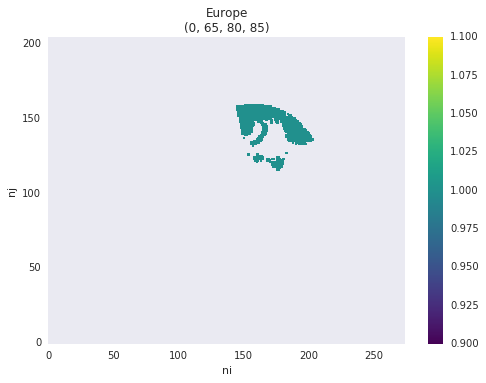

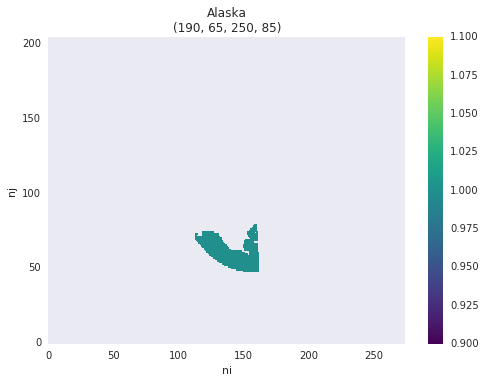

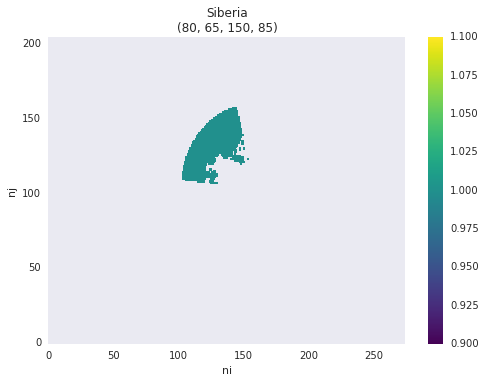

In [7]:
region_bounds = {'Siberia': [80, 65,  150, 85],
                 'Europe': [0, 65,  80, 85],
                 'Alaska': [190, 65,  250, 85]}
regions = {}
for key, (x0, y0, x1, y1) in region_bounds.items():
    if x0 < 0:
        x0 += 360
    if x1 < 0:
        x1 += 360

    if x1 < x0:
        x1, x0 = x0, x1

        regions[key] = (~((lnd_masks.xc > x0) & (lnd_masks.xc < x1)) &
                        (domain.yc > y0) & (lnd_masks.yc < y1))
    else:
        regions[key] = ((lnd_masks.xc > x0) & (lnd_masks.xc < x1) &
                        (lnd_masks.yc > y0) & (lnd_masks.yc < y1))
    
    plt.figure()
    
    regions[key] = regions[key].where(regions[key] * lnd_masks.mask)
    
    (regions[key]).plot()
    plt.title(key + '\n' + str((x0, y0, x1, y1)))

In [8]:
for mask, title in zip(['mask_rof_to_centralarctic', 'mask_ob', 'mask_tundra', 'Serreze'],
                       ['Central Arctic Drainage', 'Ob River', 'Tundra', 'Serreze 2006 Mask']):
    regions[title] = lnd_masks[mask]
regions['Tundra_N65'] = lnd_masks['mask_tundra'].where(lnd_masks.yc > 65)

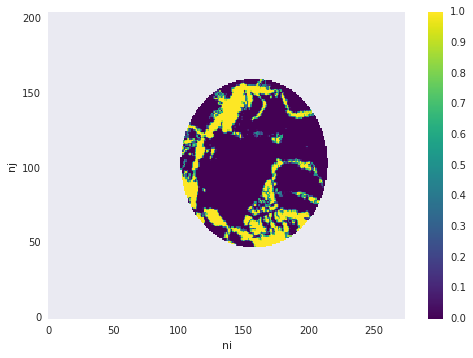

In [9]:
regions['Tundra_N65'].plot()

In [10]:
obs_extent = read_obs_seaice_extent()

# dsets = ['Adam', 'RASM', 'MERRA', 'ERA']
dsets = ['MERRA', 'ERA']
colors = ['#95a5a6', '#e74c3c', '#3498db', '#2ecc71', '#34495e', 'k']

season_type = 'Oct-Dec'  # or 'Sep-Nov'

grid_data = {}
for k in dsets:
    rs, m = get_season_sum_items(season_type)
    da = read_grid_prec(k).resample(rs, how='sum', dim='time')
    grid_data[k] = da.sel(time=da['time.month'] == m).resample('AS', dim='time', how='mean')

Tundra_N65 	 ERA 	 1979: SpearmanrResult(correlation=-0.26526610644257703, pvalue=0.12354086390158642)
Tundra_N65 	 ERA 	 1979:2000 SpearmanrResult(correlation=0.10519480519480517, pvalue=0.64996728472964893)
Tundra_N65 	 MERRA 	 1979: SpearmanrResult(correlation=-0.28487394957983198, pvalue=0.097176097364207237)
Tundra_N65 	 MERRA 	 1979:2000 SpearmanrResult(correlation=-0.087012987012987, pvalue=0.70763080102688058)
Central Arctic Drainage 	 ERA 	 1979: SpearmanrResult(correlation=-0.40476190476190482, pvalue=0.015870962099409677)
Central Arctic Drainage 	 ERA 	 1979:2000 SpearmanrResult(correlation=-0.40779220779220782, pvalue=0.066503047247961369)
Central Arctic Drainage 	 MERRA 	 1979: SpearmanrResult(correlation=-0.3826330532212886, pvalue=0.023293718519993133)
Central Arctic Drainage 	 MERRA 	 1979:2000 SpearmanrResult(correlation=-0.42467532467532471, pvalue=0.054996018009894163)
Ob River 	 ERA 	 1979: SpearmanrResult(correlation=0.0061624649859943984, pvalue=0.9719729955454362

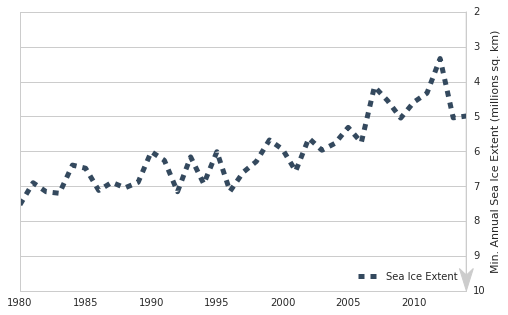

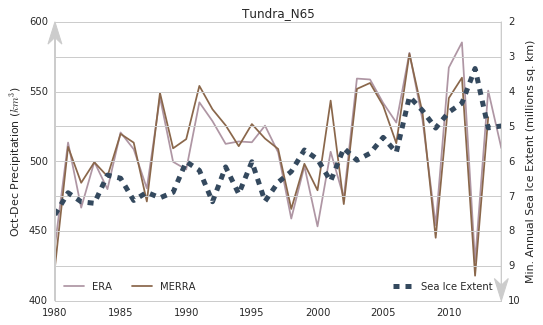

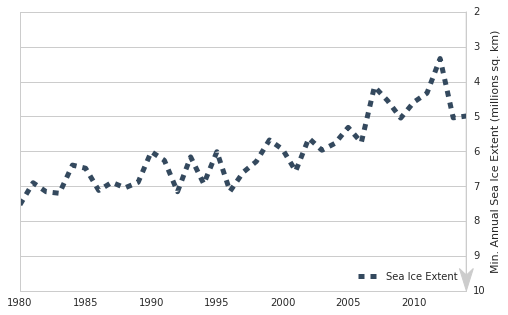

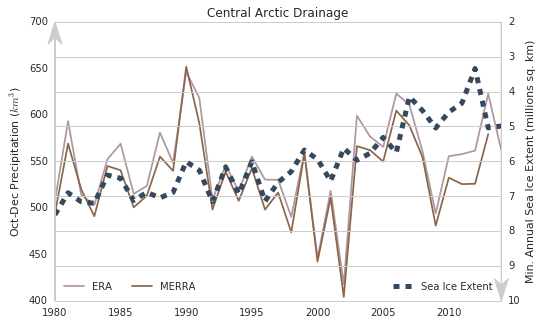

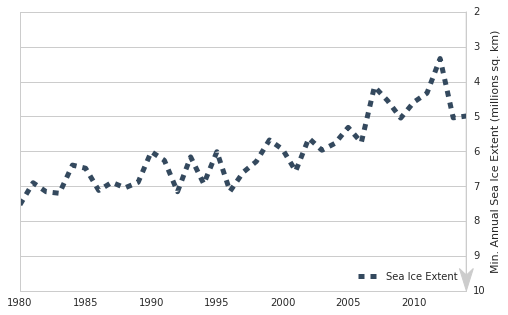

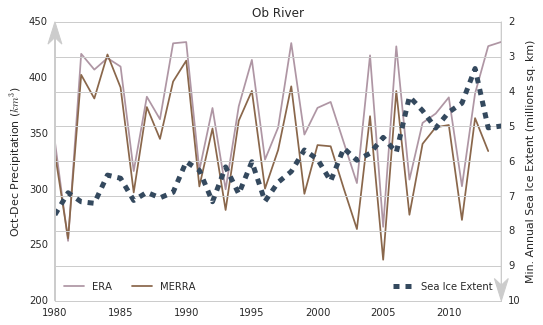

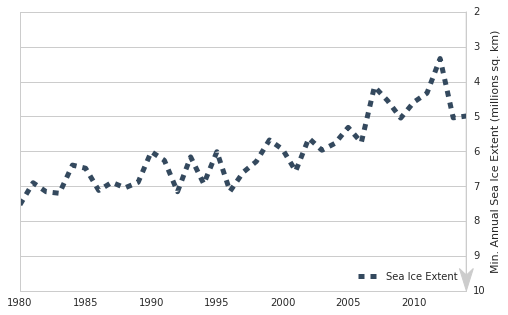

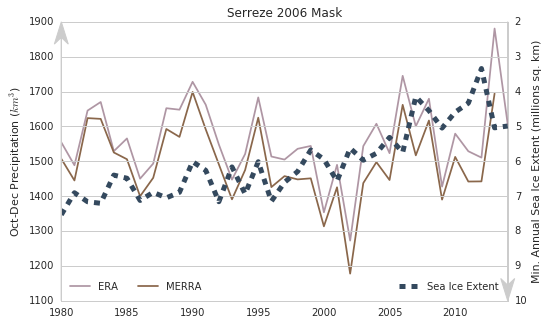

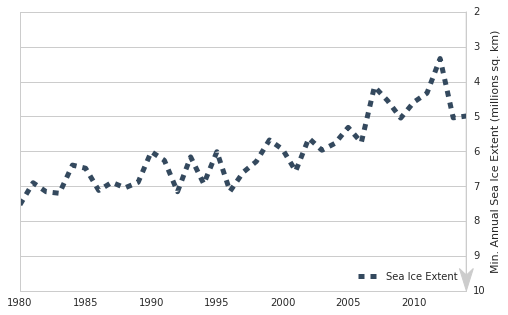

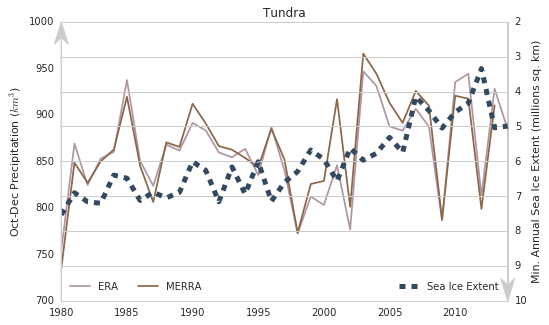

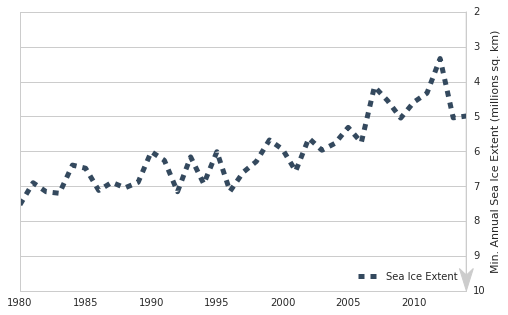

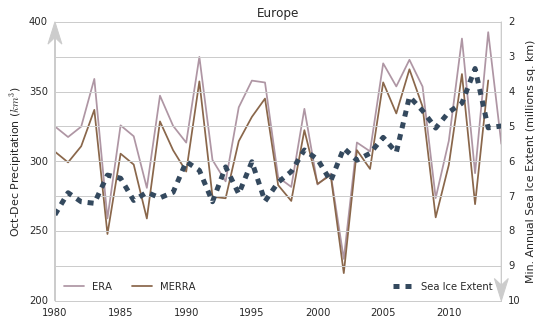

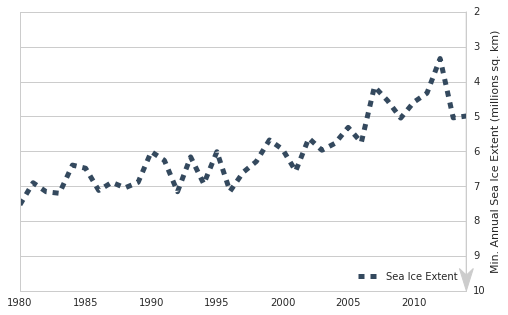

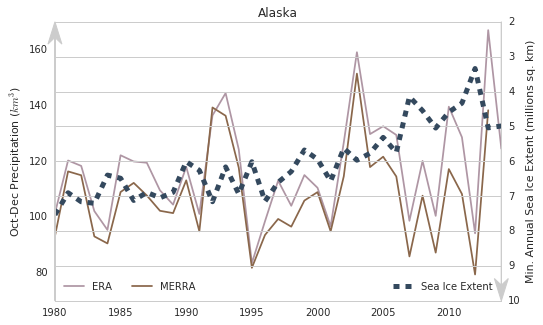

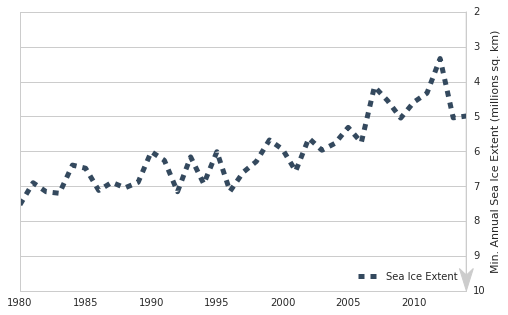

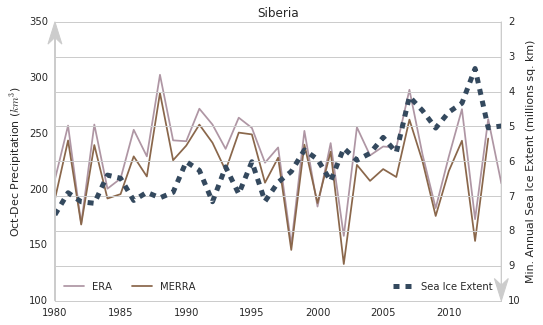

In [11]:
# mask = 'Serreze'
# title = 'Serreze 2006 Mask'

# # mask = 'mask_rof_to_centralarctic'
# # title = 'Central Arctic'

dsets = [ 'MERRA', 'ERA']
pal = sns.color_palette(palette='colorblind', n_colors=4, desat=0.3)
# colors = {'Adam': '#95a5a6',
#           'RASM': '#e74c3c',
#           'MERRA': '#3498db',
#           'ERA': '#2ecc71',
#           'Sea Ice Extent': '#34495e'}

colors = {'Adam': pal[0],
          'RASM': pal[1],
          'MERRA': pal[2],
          'ERA': pal[3],
          'Sea Ice Extent': '#34495e'}

lws = {'Adam': 1.75,
       'RASM': 1.75,
       'MERRA': 1.75,
       'ERA': 1.75,
       'Sea Ice Extent': 5}

for title, mask in regions.items():
    
    prec_ts = {}
    for k in dsets:
#         prec_ts[k] = grid_data[k].where(mask > 0).mean(dim=('ni', 'nj')).to_series()
        prec_ts[k] = mask_to_vol_series(grid_data[k], mask)

    df = pd.DataFrame(prec_ts)['1979':]
    df['Sea Ice Extent'] = obs_extent.resample('AS').min()

    # Plot timeseries
    with sns.axes_style("whitegrid"):

        sns.set_palette('colorblind')
        fig2, ax_seaice_only = plt.subplots(figsize=(8, 5))
        fig1, ax_all = plt.subplots(figsize=(8, 5))

        for ax, sea_ice_only in [(ax_all, False), (ax_seaice_only, True)]:

            for k in df:
                kwargs = dict(ax=ax, lw=lws[k], color=colors[k])
                if k == 'Sea Ice Extent':
                    kwargs['secondary_y'] = True
                    kwargs['style'] = '--'
                if k != 'Sea Ice Extent' and sea_ice_only:
                    kwargs['lw'] = 0

                df[k].plot(**kwargs)

            ax.set_xlabel('')


            ax.right_ax.set_ylabel('Min. Annual Sea Ice Extent (millions sq. km)')
            ax.right_ax.invert_yaxis()
            ax.right_ax.set_ylim(10, 2)
            
#             ax.set_ylim(40, 120)

            if sea_ice_only:
                ax.set_yticklabels([])
            else:
                draw_axis_arrows(right=False)
                ax.set_title(title)
                ax.set_ylabel('%s Precipitation ($km^3$)' % season_type)
                ax.legend(loc='lower left', ncol=2)
        
            ax.right_ax.legend(loc='lower right')

            draw_axis_arrows(right=True)

        for k, s in df.items():
            if k == 'Sea Ice Extent':
                continue
            print(title, '\t', k, '\t', '1979:', spearmanr(df['1979':]['Sea Ice Extent'], s))
            print(title, '\t', k, '\t', '1979:2000', spearmanr(df['1979':'2000']['Sea Ice Extent'], s['1979':'2000']))

#         print(mask, '\n', df['1979':].corr()['Sea Ice Extent'])
#         print(mask, '\n', df['1979': '2000'].corr()['Sea Ice Extent'])


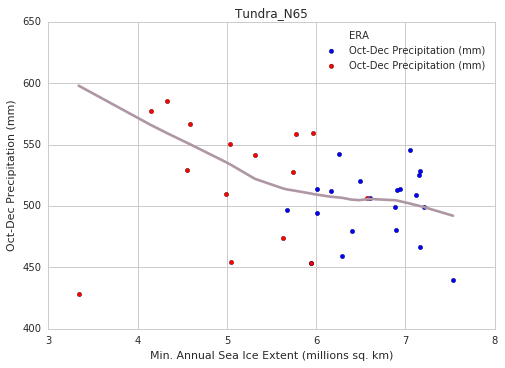

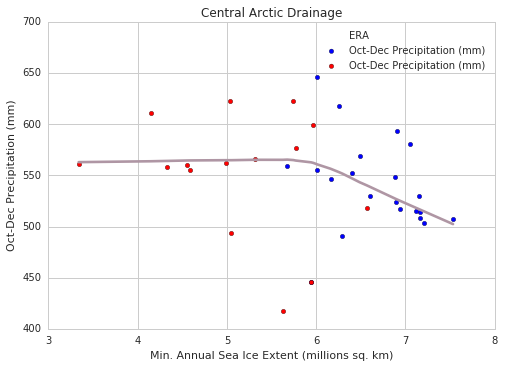

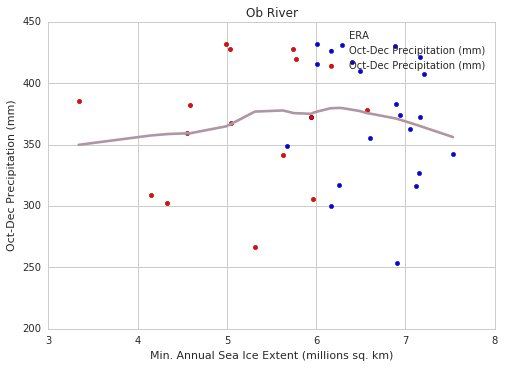

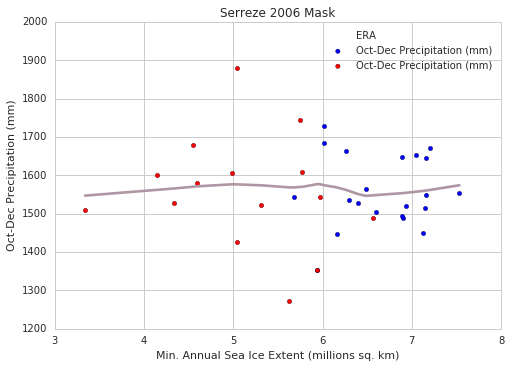

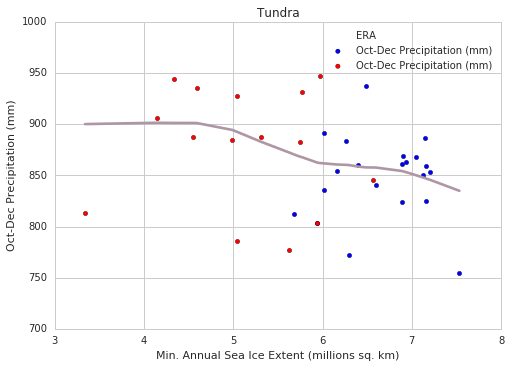

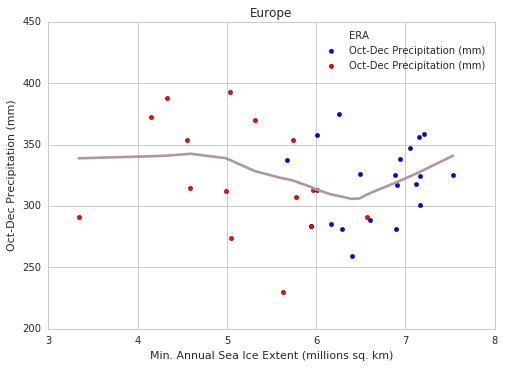

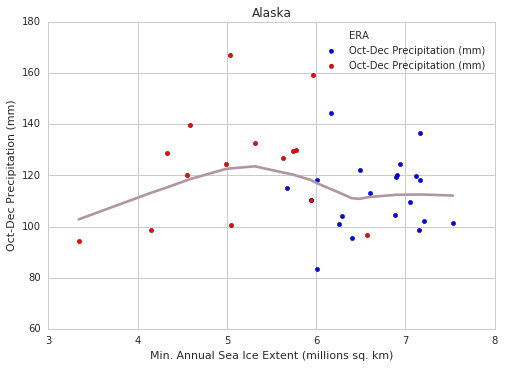

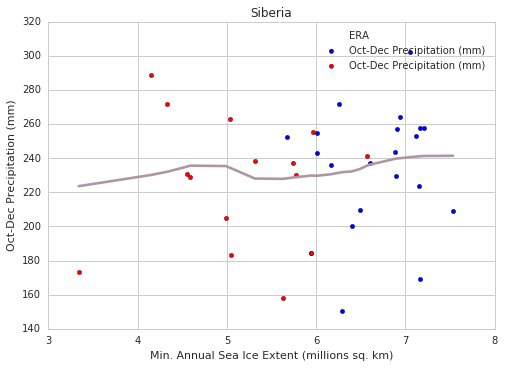

In [12]:
with sns.axes_style("whitegrid"):
    for title, mask in regions.items():

        prec_ts = {}

        for k in dsets:
            prec_ts[k] = mask_to_vol_series(grid_data[k], mask)

        df = pd.DataFrame(prec_ts)
        x = obs_extent.resample('AS').min()
        fig, ax = plt.subplots()
        for i, k in enumerate(dsets):
            if i > 0:
                ylab = '%s Precipitation (mm)' % season_type
                temp = pd.DataFrame({'Sea Ice Extent': x,  ylab: df[k]})       
                sns.regplot('Sea Ice Extent', ylab, temp['1979': '2015'],
                            scatter_kws=dict(marker='o', facecolor='none', color='black'),
                            ax=ax, label=k, color=colors[k], fit_reg=True, lowess=True)
                ax.scatter(temp['1979': '2000']['Sea Ice Extent'], temp['1979': '2000'][ylab], c='b')
                ax.scatter(temp['2000':]['Sea Ice Extent'], temp['2000':][ylab], c='r')
                

        plt.legend()
        ax.set_title(title)
        ax.set_xlabel('Min. Annual Sea Ice Extent (millions sq. km)')
        
        

In [13]:
obs_extent_da = xr.DataArray.from_series(obs_extent.resample('AS').min()[1:]).rename({'index': 'time'})

from scipy.stats import spearmanr

corr_r_data = {}
corr_p_data = {}
for k in dsets:
    corr_r_data[k] = full_like(grid_data[k].isel(time=0).drop('time'))
    corr_p_data[k] = full_like(grid_data[k].isel(time=0).drop('time'))
    
    extent_data, prec_data = xr.align(obs_extent_da, grid_data[k].sel(time=slice('1980', '2000')), join='inner')
    
    for index, mask_val in np.ndenumerate(lnd_masks['mask_active_atmosphere']):
        if mask_val > 0:
            corr_r_data[k].values[index], corr_p_data[k].values[index] = spearmanr(extent_data.values, prec_data.values[:, index[0], index[1]])

da_rs = xr.concat([corr_r_data[k] for k in dsets],
                  dim=xr.DataArray(dsets, dims=('Dataset', ), name='Dataset'),
                  coords='minimal')  # .where(lnd_masks['mask'])

da_ps = xr.concat([corr_p_data[k] for k in dsets],
                  dim=xr.DataArray(dsets, dims=('Dataset', ), name='Dataset'),
                  coords='minimal')  # .where(lnd_masks['mask'])

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


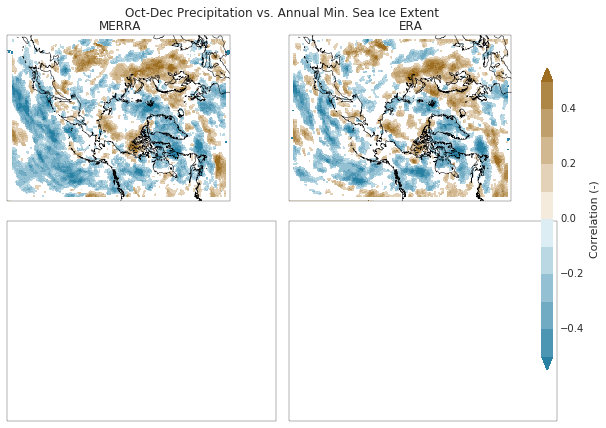

In [14]:
cmap_n = 11
cmap = sns.diverging_palette(230, 50, s=90, l=50, sep=4, n=cmap_n, as_cmap=True)


with sns.axes_style("darkgrid"):

    fig, axes = plt.subplots(2, 2, figsize=(8, 6), subplot_kw=dict(projection=Rasm()))

    for dset, ax in zip(dsets, axes.flat):
        mappable = da_rs.sel(Dataset=dset).where(da_ps.sel(Dataset=dset) < 0.5).plot.pcolormesh(
                'xc', 'yc', ax=ax, transform=ccrs.PlateCarree(),
                add_colorbar=False, levels=cmap_n, extend='both',
                vmin=-.5, vmax=0.5, cmap=cmap)
        ax.set_title(dset, horizontalalignment='right', fontsize=12)
        ax.coastlines(resolution='50m', lw=0.5, color='k')

    fig.subplots_adjust(wspace=0.05, hspace=0.1)

    cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    cb = plt.colorbar(mappable=mappable, cax=cax, drawedges=True)
    cb.set_label('Correlation (-)')
    fig.suptitle('%s Precipitation vs. Annual Min. Sea Ice Extent' % season_type, y=0.99)
    
fig.tight_layout()

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


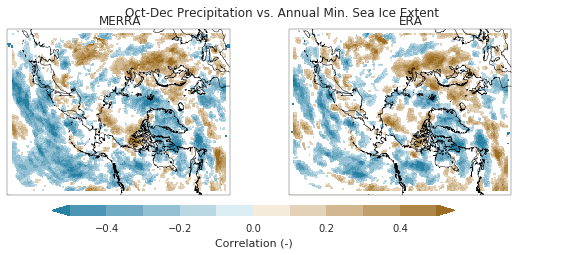

In [15]:
cmap_n = 11
cmap = sns.diverging_palette(230, 50, s=90, l=50, sep=4, n=cmap_n, as_cmap=True)


with sns.axes_style("darkgrid"):

    fig, axes = plt.subplots(1, 2, figsize=(8, 3), subplot_kw=dict(projection=Rasm()))

    for dset, ax in zip(dsets, axes.flat):
        mappable = da_rs.sel(Dataset=dset).where(da_ps.sel(Dataset=dset) < 0.5).plot.pcolormesh(
                'xc', 'yc', ax=ax, transform=ccrs.PlateCarree(),
                add_colorbar=False, levels=cmap_n, extend='both',
                vmin=-.5, vmax=0.5, cmap=cmap)
        ax.set_title(dset, horizontalalignment='right', fontsize=12)
        ax.coastlines(resolution='50m', lw=0.5, color='k')

    fig.subplots_adjust(wspace=0.05, hspace=0.)

    cax = fig.add_axes([0.1, 0.02, 0.7, 0.05])
    cb = plt.colorbar(mappable=mappable, cax=cax, drawedges=True, orientation='horizontal')
    cb.set_label('Correlation (-)')
    fig.suptitle('%s Precipitation vs. Annual Min. Sea Ice Extent' % season_type, y=0.99)
    
fig.tight_layout()

In [16]:
slope_data = OrderedDict()
k = 'Adam'

# Oct-Dec
da = read_grid_prec(k).rolling(time=3).sum()
da /= 3
da  = da.sel(time=da['time.month'] == 12).resample('AS', how='mean', dim='time')
slope_data['Oct-Dec'] = wrap_theilslopes(da.isel(time=slice(1, None, None)))

# Oct-Mar
da = read_grid_prec(k).rolling(time=6).sum()
da /= 6
da  = da.sel(time=da['time.month'] == 3).resample('AS', how='mean', dim='time')
slope_data['Oct-Mar'] = wrap_theilslopes(da.isel(time=slice(1, None, None)))

# annual trend
da = read_grid_prec(k).rolling(time=12).sum()
da /= 12
da  = da.sel(time=da['time.month'] == 9).resample('AS', how='mean', dim='time')
slope_data['Oct-Sep'] = wrap_theilslopes(da.isel(time=slice(1, None, None)))

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


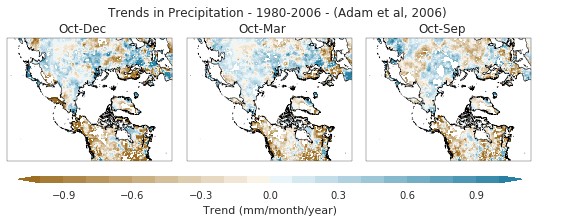

In [17]:
cmap_n = 21
cmap = sns.diverging_palette(50, 230, s=90, l=50, sep=10, n=cmap_n, as_cmap=True)

with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5), subplot_kw=dict(projection=Rasm()))

    for (k, da), ax in zip(slope_data.items(), axes):
        insig = same_sign(da.up_slope, da.lo_slope)
        da_plot = da.slope.where(~insig)

        da_plot['yc'] = lnd_masks.yc
        da_plot['xc'] = lnd_masks.xc

        mappable = da_plot.plot.pcolormesh('xc', 'yc', ax=ax, transform=ccrs.PlateCarree(),
                                            add_colorbar=False, levels=cmap_n, extend='both',
                                            cmap=cmap, vmin=-1, vmax=1)
        ax.set_title(k, horizontalalignment='right', fontsize=12)
#         ax.add_geometries(perm_geom,
#                           ccrs.PlateCarree(),
#                           facecolor='None', lw=1.25, edgecolor='#34495e')
        ax.coastlines(resolution='50m', lw=0.5, color='k')

    fig.subplots_adjust(wspace=-0.1, hspace=-1)

    cax = fig.add_axes([0.14, 0.28, 0.7, 0.02])
    cb = plt.colorbar(mappable=mappable, cax=cax, drawedges=True, orientation='horizontal')
    cb.set_label('Trend (mm/month/year)')
    fig.suptitle('Trends in Precipitation - 1980-2006 - (Adam et al, 2006)', y=0.77)

    # fig.tight_layout()

In [18]:
convergence_dsets = ['ERA', 'RASM']
    
season_type = 'Sep-Nov'
    
grid_data = {}
for k in convergence_dsets:
    if season_type == 'Nov-Dec':
        grid_data[k] = read_grid_convergence(k).resample('2M', how='mean', dim='time')
        grid_data[k] = grid_data[k].sel(time=grid_data[k]['time.month'] == 11).resample('AS', dim='time', how='mean')
    elif season_type == 'Sep-Nov':
        grid_data[k] = read_grid_convergence(k).resample('QS-SEP', how='mean', dim='time')
        grid_data[k] = grid_data[k].sel(time=grid_data[k]['time.month'] == 9).resample('AS', dim='time', how='mean')        
    else:
        raise ValueError('Unknown season type %s' % season_type)

In [19]:
re = 6.37122e6

area = ocn_masks['cell_area']

In [20]:
polar_cap_mask = lnd_masks.mask_active_atmosphere.where(lnd_masks.yc > 60)

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


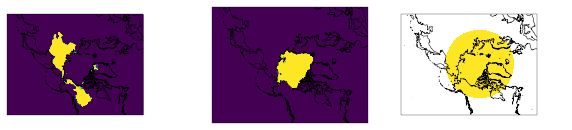

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5), subplot_kw=dict(projection=Rasm()))

lnd_masks['mask_rof_to_centralarctic'].plot.pcolormesh('xc', 'yc', ax=axes[0], transform=ccrs.PlateCarree(), vmin=0, vmax=1,
                                            add_colorbar=False)
ocn_masks['mask_centralarctic'].plot.pcolormesh('longitude', 'latitude', ax=axes[1], transform=ccrs.PlateCarree(), vmin=0, vmax=1,
                                            add_colorbar=False)
polar_cap_mask.plot.pcolormesh('xc', 'yc', ax=axes[2], transform=ccrs.PlateCarree(), vmin=0, vmax=1,
                                            add_colorbar=False)

[ax.coastlines(resolution='50m', lw=0.5, color='k') for ax in axes]

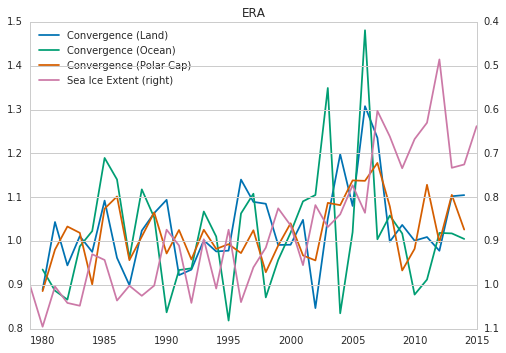

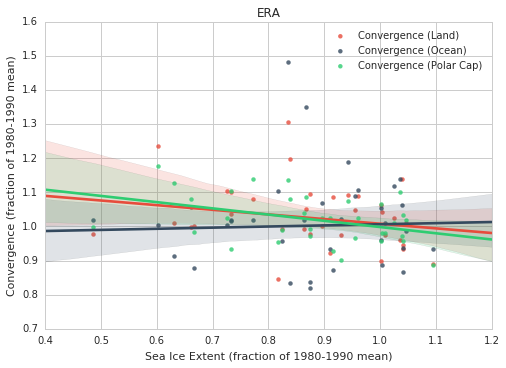

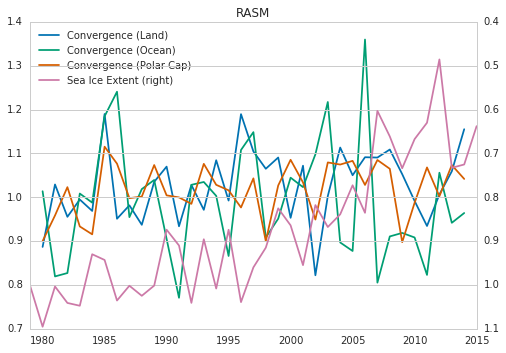

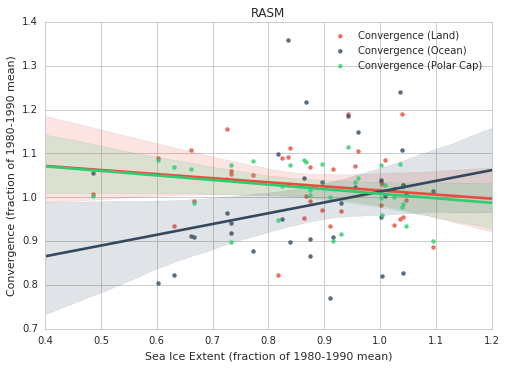

In [22]:
for k in convergence_dsets:
    
    df = pd.DataFrame({'Convergence (Land)': mask_to_vol_series(grid_data[k], lnd_masks['mask_rof_to_centralarctic']),
                       'Convergence (Ocean)': mask_to_vol_series(grid_data[k], ocn_masks['mask_centralarctic']),
                       'Convergence (Polar Cap)': mask_to_vol_series(grid_data[k], polar_cap_mask),
                       'Sea Ice Extent': obs_extent.resample('AS').min()})['1979':]
    df = (df / df[:'1990'].mean())
    with sns.axes_style("whitegrid"):
        plt.figure()
        ax = plt.subplot()
        df.plot(secondary_y='Sea Ice Extent', ax=ax)
        ax.right_ax.invert_yaxis()
        plt.title(k)


        plt.figure()
        ax = plt.subplot()
        for y, color in zip(['Convergence (Land)', 'Convergence (Ocean)', 'Convergence (Polar Cap)'],
                            ['#e74c3c', '#34495e', '#2ecc71']):
            sns.regplot(x='Sea Ice Extent', y=y, data=df, color=color, ax=ax, label=y, robust=True)
            ax.set_ylabel('Convergence (fraction of 1980-1990 mean)')
            ax.set_xlabel('Sea Ice Extent (fraction of 1980-1990 mean)')
        plt.legend()
        plt.title(k)

In [23]:
tslice = slice('1979', '2000')
pearson_r_data = {}
for k in convergence_dsets:
    pearson_r_data[k] = full_like(grid_data[k].isel(time=0).drop('time'))
    
    extent_data, prec_data = xr.align(obs_extent_da.sel(time=tslice), grid_data[k].sel(time=tslice), join='inner')
    
    for index, mask_val in np.ndenumerate(lnd_masks['mask']):
        if mask_val > 0:
            pearson_r_data[k].values[index], _ = pearsonr(extent_data.values, prec_data.values[:, index[0], index[1]])

da_rs = xr.concat([pearson_r_data[k] for k in convergence_dsets],
                  dim=xr.DataArray(convergence_dsets, dims=('Dataset', ), name='Dataset'),
                  coords='minimal').where(lnd_masks['mask'])

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


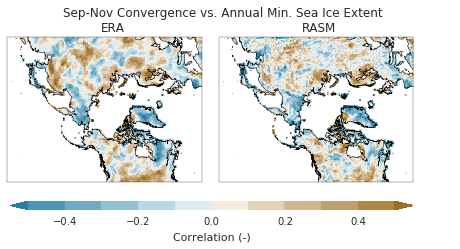

In [24]:
cmap_n = 11
cmap = sns.diverging_palette(230, 50, s=90, l=50, sep=4, n=cmap_n, as_cmap=True)


with sns.axes_style("darkgrid"):

    fig, axes = plt.subplots(1, 2, figsize=(8, 6), subplot_kw=dict(projection=Rasm()))

    for dset, ax in zip(convergence_dsets, axes.flat):
        mappable = da_rs.sel(Dataset=dset).plot.pcolormesh('xc', 'yc', ax=ax, transform=ccrs.PlateCarree(),
                                                           add_colorbar=False, levels=cmap_n, extend='both',
                                                           vmin=-.5, vmax=0.5, cmap=cmap)
        ax.set_title(dset, horizontalalignment='right', fontsize=12)
#         ax.add_geometries(perm_geom,
#                           ccrs.PlateCarree(),
#                           facecolor='None', lw=1.25, edgecolor='#34495e')
        ax.coastlines(resolution='50m', lw=0.5, color='k')

    fig.subplots_adjust(wspace=-0.1, hspace=-0.1)

    cax = fig.add_axes([0.13, 0.28, 0.7, 0.02])
    cb = plt.colorbar(mappable=mappable, cax=cax, drawedges=True, orientation='horizontal')
    cb.set_label('Correlation (-)')
    fig.suptitle('%s Convergence vs. Annual Min. Sea Ice Extent' % season_type, y=0.75)

In [25]:
rasm_sea_ice = xr.open_dataset('../data/sea_ice_timeseries.nc')
rasm_wb = xr.open_dataset('../data/wb_depth_timeseries_by_mask.nc')
rasm_wb

<xarray.Dataset>
Dimensions:        (dataset: 3, mask: 4, time: 424)
Coordinates:
  * time           (time) datetime64[ns] 1979-09-01 1979-10-01 1979-11-01 ...
  * mask           (mask) object 'serreze_land' 'serreze_ocean' ...
  * dataset        (dataset) object '$RASM_{CONTROL}$' '$RASM_{RSI}$' ...
Data variables:
    Precipitation  (dataset, mask, time) float64 1.618 1.29 1.032 0.8286 ...
    Runoff         (dataset, mask, time) float64 0.3622 0.182 0.05304 ...
    Evaporation    (dataset, mask, time) float64 -0.7441 -0.1771 -0.01222 ...

In [26]:
dpm = xr.DataArray(get_dpm(rasm_wb.time.to_index(), calendar='noleap'),
                   dims=('time', ), coords={'time': rasm_wb.time}, name='dpm')

In [27]:
rasm_wb *= dpm

In [28]:
ice_df = rasm_sea_ice['extent'].resample('AS', how='min', dim='time').T.to_pandas()

In [29]:
ice_df.head()

dataset,$RASM_{CONTROL}$,$RASM_{RSI}$,$RASM_{RSH}$
time,,,
1979-01-01,6.905688e+06,6.873357e+06,2.426087e+05
1980-01-01,6.735141e+06,6.499312e+06,3.501107e+06
1981-01-01,6.472891e+06,6.138111e+06,3.044562e+06
1982-01-01,6.373766e+06,5.940006e+06,3.421132e+06
1983-01-01,6.267338e+06,5.884979e+06,3.607417e+06


In [30]:
rasm_sims = ['$RASM_{CONTROL}$', '$RASM_{RSI}$', '$RASM_{RSH}$']

In [31]:
rasm_wb['Precipitation']

<xarray.DataArray 'Precipitation' (dataset: 3, mask: 4, time: 424)>
array([[[ 48.52737425,  39.98162026,  30.96167364, ...,  41.89597881,
          28.97763652,  23.95327498],
        [ 39.49628877,  23.65723758,  22.68492648, ...,  23.06960366,
          20.0326917 ,  16.78817088],
        [ 47.73033408,  32.37039625,  21.90316889, ...,  39.12325996,
          24.70776284,  19.10636569],
        [ 31.01507809,  18.70109953,  17.39184615, ...,  21.2932218 ,
          14.64514828,  10.87807151]],

       [[ 50.16116278,  38.47871859,  30.38989213, ...,  42.83093566,
          28.95876214,  24.07838725],
        [ 39.57735326,  22.70979194,  21.7448659 , ...,  25.29969699,
          21.1766723 ,  16.19688041],
        [ 49.31675917,  30.59015769,  21.7508354 , ...,  39.75575363,
          24.66708811,  19.36874867],
        [ 30.31221111,  17.66260815,  16.21137293, ...,  23.59955272,
          15.42188241,   9.97118252]],

       [[ 48.51710319,  38.84475925,  30.31869235, ...,  43.9764

In [32]:
season_type = 'Oct-Dec'  # or 'Sep-Nov'
rs, m = get_season_sum_items(season_type)
da = rasm_wb['Precipitation'].sel(mask='serreze_land').resample(rs, how='sum', dim='time')
prec_df = da.sel(time=da['time.month'] == m).resample('AS', dim='time', how='first').T.to_pandas()
#.rename(
#     columns={'rasm_cpl_era_monthly_ts': 'R1010RBRbaaa01a',
#              'rasm_cpl_era_monthly_ts_rsi': 'R1010RBRbrsi01a',
#              'rasm_cpl_era_monthly_ts_rsh': 'R1010RBRbrsh01a',
#              'era_monthly_ts3': 'ERA-Interim'})

prec_df.head()

dataset,$RASM_{CONTROL}$,$RASM_{RSI}$,$RASM_{RSH}$
time,,,
1979-01-01,96.630766,95.031226,94.905415
1980-01-01,88.651853,91.720657,92.929136
1981-01-01,86.697161,86.444004,92.617353
1982-01-01,98.722344,100.304769,103.678072
1983-01-01,91.979137,94.844440,95.574964


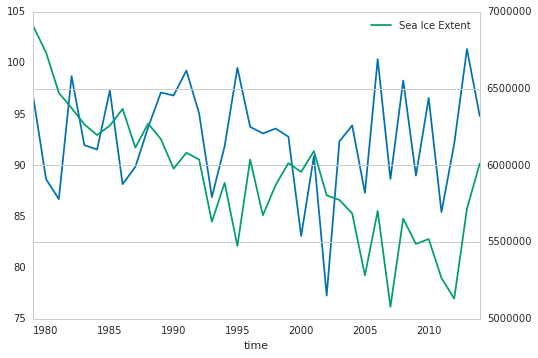

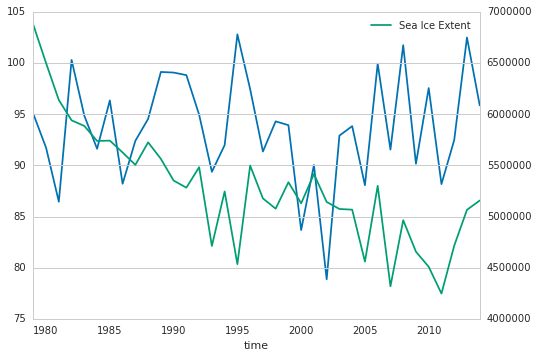

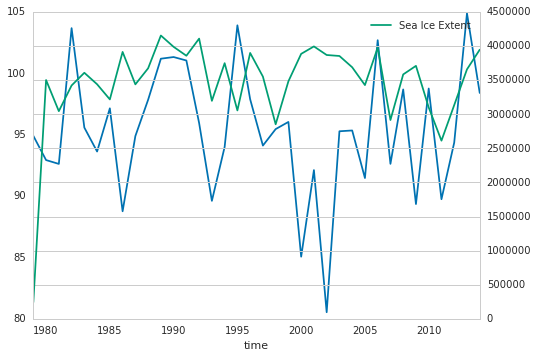

In [33]:
sns.set_style('whitegrid')
for dataset in rasm_sims:
    plt.figure()
    prec_df[dataset].plot(label='Precipitation')
    ice_df[dataset].plot(secondary_y=True, label='Sea Ice Extent')
    plt.legend()

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


mask_rof_to_centralarctic 
 dataset
$RASM_{CONTROL}$    0.109069
Sea Ice Extent      1.000000
Name: Sea Ice Extent, dtype: float64
mask_rof_to_centralarctic 
 dataset
$RASM_{CONTROL}$   -0.053316
Sea Ice Extent      1.000000
Name: Sea Ice Extent, dtype: float64
mask_rof_to_centralarctic 
 dataset
$RASM_{RSI}$      0.058916
Sea Ice Extent    1.000000
Name: Sea Ice Extent, dtype: float64
mask_rof_to_centralarctic 
 dataset
$RASM_{RSI}$     -0.086475
Sea Ice Extent    1.000000
Name: Sea Ice Extent, dtype: float64
mask_rof_to_centralarctic 
 dataset
$RASM_{RSH}$      0.058026
Sea Ice Extent    1.000000
Name: Sea Ice Extent, dtype: float64
mask_rof_to_centralarctic 
 dataset
$RASM_{RSH}$      0.048661
Sea Ice Extent    1.000000
Name: Sea Ice Extent, dtype: float64


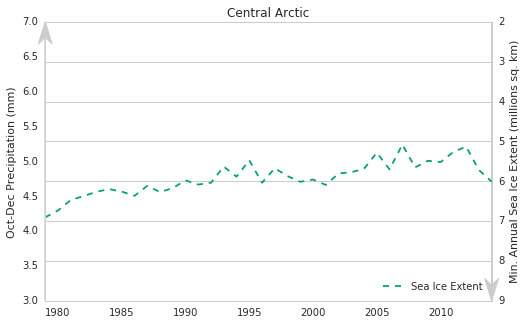

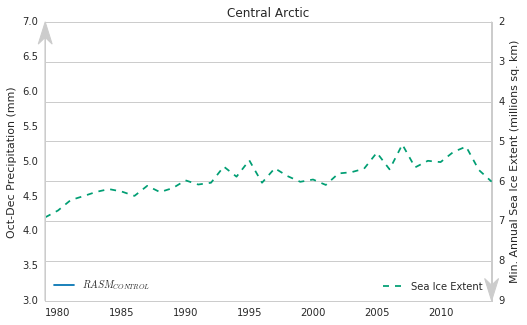

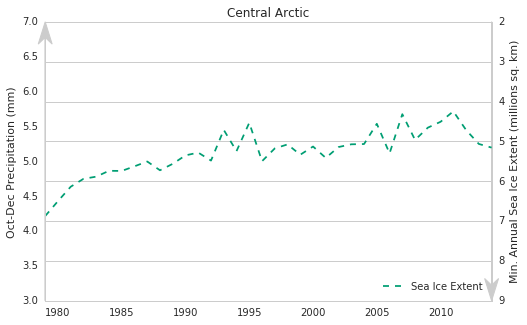

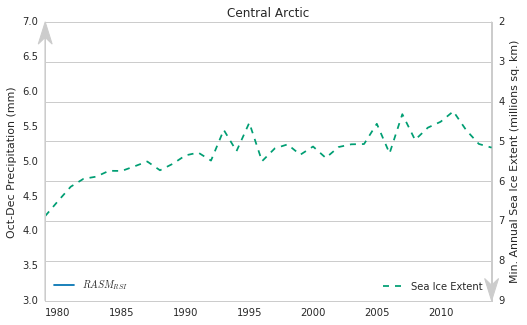

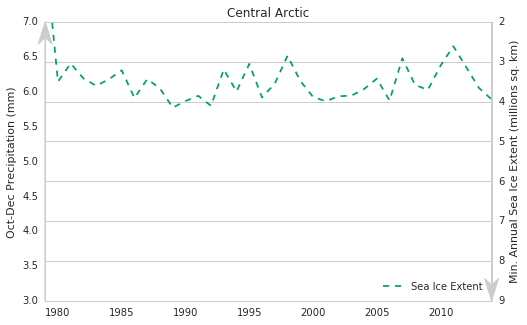

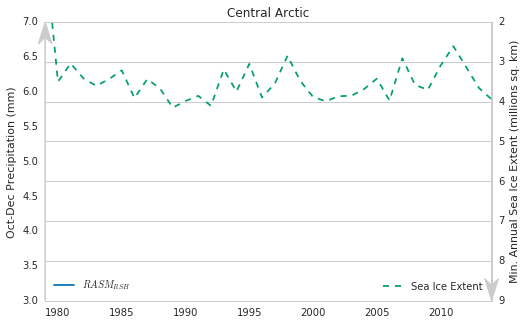

In [34]:
mask = 'mask_rof_to_centralarctic'
title = 'Central Arctic'

dsets = ['Adam', 'RASM', 'MERRA', 'ERA']
pal = sns.color_palette(palette='colorblind', n_colors=4, desat=0.3)
# colors = {'Adam': '#95a5a6',
#           'RASM': '#e74c3c',
#           'MERRA': '#3498db',
#           'ERA': '#2ecc71',
#           'Sea Ice Extent': '#34495e'}

colors = {'Adam': pal[0],
          'RASM': pal[1],
          'MERRA': pal[2],
          'ERA': pal[3],
          'Sea Ice Extent': '#34495e'}

lws = {'Adam': 1.75,
       'RASM': 1.75,
       'MERRA': 1.75,
       'ERA': 1.75,
       'Sea Ice Extent': 5}
    
# prec_ts = {}
# for k in dsets:
#     prec_ts[k] = (lnd_masks[mask] * grid_data[k]).mean(dim=('ni', 'nj')).to_series()

for dataset in rasm_sims:

    df = prec_df[[dataset]]
    df['Sea Ice Extent'] = ice_df[dataset] / 1000 / 1000

    # Plot timeseries
    with sns.axes_style("whitegrid"):
        sns.set_palette('colorblind')
        fig2, ax_seaice_only = plt.subplots(figsize=(8, 5))
        fig1, ax_all = plt.subplots(figsize=(8, 5))

        for ax, sea_ice_only in [(ax_all, False), (ax_seaice_only, True)]:

            for k in df:
                kwargs = dict(ax=ax) #, lw=lws[k], color=colors[k])
                if k == 'Sea Ice Extent':
                    kwargs['secondary_y'] = True
                    kwargs['style'] = '--'
                if k != 'Sea Ice Extent' and sea_ice_only:
                    kwargs['lw'] = 0

                df[k].plot(**kwargs)

            ax.set_xlabel('')
            ax.set_title(title)

            ax.set_ylim(3, 7)
            ax.set_ylabel('%s Precipitation (mm)' % season_type)

            ax.right_ax.set_ylabel('Min. Annual Sea Ice Extent (millions sq. km)')
            ax.right_ax.invert_yaxis()
            ax.right_ax.set_ylim(9, 2)

            if not sea_ice_only:
                ax.legend(loc='lower left', ncol=2)
            ax.right_ax.legend(loc='lower right')

            draw_axis_arrows(right=False)
            draw_axis_arrows(right=True)

        print(mask, '\n', df['1979':].corr()['Sea Ice Extent'])
        print(mask, '\n', df['1979': '2000'].corr()['Sea Ice Extent'])


In [35]:
rasm_swe = read_grid_swe(kind='RASM').load()
rasm_swe_rsh = read_grid_swe(kind='RASM_RSH').load()


In [36]:
rasm_ds = xr.open_dataset('/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/lnd/monthly_mean_timeseries/R1010RBRbaaa01a.vic.hmm.197909-201412.nc').sel(time=slice('1990', '2015')).rename({'x': 'ni', 'y': 'nj'})
rasm_rsh_ds = xr.open_dataset('/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsh01a/lnd/monthly_mean_timeseries/R1010RBRbrsh01a.vic.hmm.197909-201412.nc').sel(time=slice('1990', '2015')).rename({'x': 'ni', 'y': 'nj'})

for label, ds in [('Control', rasm_ds), ('RSH', rasm_rsh_ds)]:
    ds['tgrad'] = ds['Tair'] - ds['Tsoil'].sel(depth=0).drop('depth')
    dpm = xr.DataArray(get_dpm(ds.time.to_index(), calendar='noleap'), dims=('time', ), coords={'time': ds.time}, name='dpm')
    ds['Precipitation'] *= dpm
    

In [37]:
rasm_swe = rasm_swe.sel(time=slice('1990', '2015'))
rasm_swe_rsh = rasm_swe_rsh.sel(time=slice('1990', '2015'))

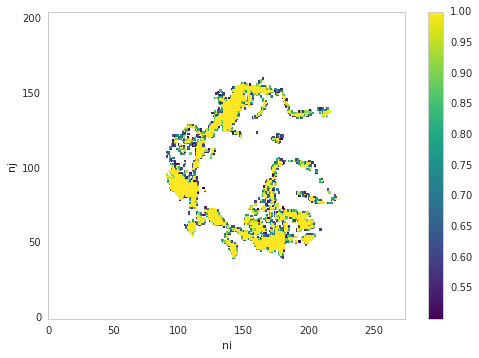

In [38]:
mask = lnd_masks['mask_tundra'].where((lnd_masks['mask_tundra'] > 0.5) &
                                      (lnd_masks['mask_tundra'].yc > 60) &
                                      (rasm_swe.min(dim='time') < 5) &
                                      (rasm_swe.max(dim='time') > 5))
mask.plot()

In [40]:
def water_year(time_index, last_month=9):
    year = time_index.to_index().year
    year[time_index.to_index().month > last_month] += 1 
    return xr.DataArray(year, dims=time_index.dims, coords=time_index.coords, name='water_year') 


def snow_disappearance_date(swe, dim='time', thresh=5):
    # create an array of indices the same shape as swe,
    diminds = xr.DataArray(np.arange(swe.time.size), dims=(dim, ), coords=swe.time.coords)
    diminds, _ = xr.broadcast(diminds, swe)
    # Find the indicies of the max swe
    maxinds = swe.argmax(dim=dim)
    # find the index of the first day where swe < thresh
    return (swe < thresh).where(diminds > maxinds).fillna(0).argmax(dim=dim)

def first_snow_date(swe, dim='time', thresh=5):
    return (swe > thresh).fillna(0).argmax(dim=dim)

In [41]:
ys, xs = np.nonzero(mask.values > 0)

In [42]:
data = {}
data['no_snow_day'] = {}
data['first_snow_day'] = {}
data['peak_swe'] = {}

for label, da in [('Control', rasm_swe), ('RSH', rasm_swe_rsh)]:
    da_groups = da.groupby(water_year(da.time, 7))
    data['no_snow_day'][label] = da_groups.apply(
            snow_disappearance_date).mean(dim='water_year')
    
    data['first_snow_day'][label] = da_groups.apply(
            first_snow_date).mean(dim='water_year')
    
    data['peak_swe'][label] = da_groups.max(dim='time').mean(dim='water_year')

In [43]:
# Look at distributions of precip, temperature, and tair-soil
data['precip'] = {}
data['temp'] = {}
data['tgrad'] = {}

for label, ds in [('Control', rasm_ds), ('RSH', rasm_rsh_ds)]:
    ds_temp = ds.sel(time=ds.indexes['time'].month > 9).where(lnd_masks['mask'])
    data['precip'][label] = ds_temp['Precipitation'].groupby('time.year').sum(dim='time').mean(dim='year')
    data['temp'][label] = ds_temp['Tair'].mean(dim='time')
    data['tgrad'][label] = ds_temp['tgrad'].mean(dim='time')


/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


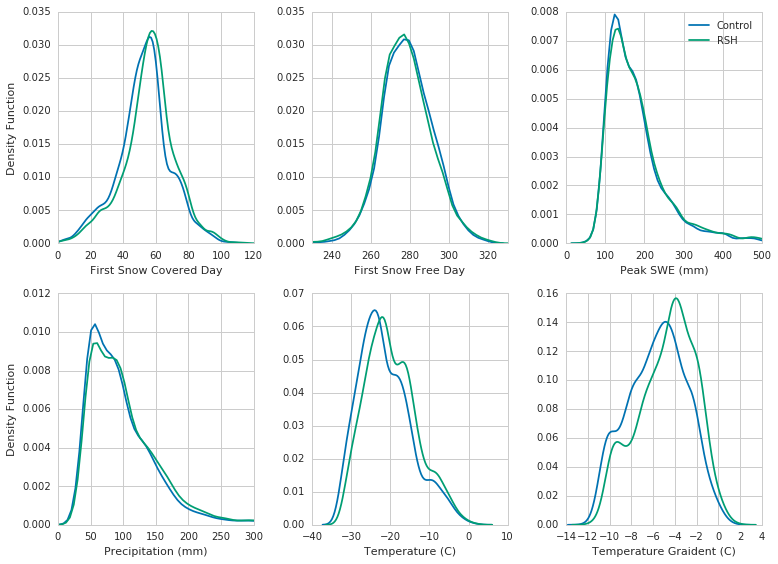

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(11, 8))

# First Snow Covered Day 
ax = axes[0, 0]
for label, da in data['first_snow_day'].items():
    sns.kdeplot(da.values[ys, xs], label=label, ax=ax, legend=False)
    ax.set_xlim(0, 120)
    ax.set_xlabel('First Snow Covered Day')
    ax.set_ylabel('Density Function')

# First Snow Free Day
ax = axes[0, 1]
for label, da in data['no_snow_day'].items():
    sns.kdeplot(da.values[ys, xs], label=label, ax=ax, legend=False)
    ax.set_xlim(230, 330)
    ax.set_xlabel('First Snow Free Day')
    
# Peak SWE
ax = axes[0, 2]
for label, da in data['peak_swe'].items():
    sns.kdeplot(da.values[ys, xs], label=label, ax=ax, gridsize=1000, legend=True)
    ax.set_xlim(0, 500)
    ax.set_xlabel('Peak SWE (mm)')
    
    
# Precipitation (OND)
ax = axes[1, 0]
for label, da in data['precip'].items():
    sns.kdeplot(da.values[ys, xs] , label=label, ax=ax, gridsize=100, legend=False)
    ax.set_xlim(0, 300)
    ax.set_xlabel('Precipitation (mm)')
    ax.set_ylabel('Density Function')

# Temperature (OND)
ax = axes[1, 1]
for label, da in data['temp'].items():
    sns.kdeplot(da.values[ys, xs], label=label, ax=ax, legend=False)
#     ax.set_xlim(0, 500)
    ax.set_xlabel('Temperature (C)')
    
# Tgrad (OND)
ax = axes[1, 2]
for label, da in data['tgrad'].items():
    sns.kdeplot(da.values[ys, xs], label=label, ax=ax, gridsize=5000, legend=False)
#     ax.set_xlim(0, 500)
    ax.set_xlabel('Temperature Graident (C)')
    
fig.tight_layout()